In [2]:
library(phyloseq)
library(ggplot2)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)
library(viridis)

In [3]:
####################
# Results Summary  #
####################

#Adonis - WUF - Significant explanatory variables inlude: Organ, Sex, PMI, & BMI (not Age, MOD)
#Adonis - UF - Significant explanatory variables inlude: Organ, Sex, Age, & MOD (not sex, PMI, BMI)
#Adonis - Bray-Curtis - Significant explanatory variables inlude: Organ, Sex, Age, MOD, PMI, & BMI

In [7]:
setwd("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/final_biom/")

biom <- import_biom("all_cohorts_cadaver_deblur.biom")
map <- import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Ita.df.MOD.txt")
tree <- read_tree("rep_phylo.tre")
cadaver_nt <- merge_phyloseq(biom,tree,map)
cadaver_nt <- prune_samples(sample_sums(cadaver_nt) > 1000, cadaver_nt)
cadaver <- merge_phyloseq(biom,tree,map) %>%
    prune_samples((sample_sums(.) > 1000), .) %>%
    filter_taxa(function(x) sum(x > 3) > (0.001*length(x)), TRUE) %>%
    transform_sample_counts(function(x) x / sum(x))

Warning message in strsplit(msg, "\n"):
“input string 1 is invalid in this locale”

In [4]:
#Subset to Italian data only
Ita = subset_samples(cadaver, Location=="Italy")
Ita.df = data.frame(sample_data(Ita))

In [5]:
Ita

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 771 taxa and 158 samples ]
sample_data() Sample Data:       [ 158 samples by 21 sample variables ]
tax_table()   Taxonomy Table:    [ 771 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 771 tips and 769 internal nodes ]

In [6]:
#Replace variable manners of death with correct category
Ita.df$The_manner_of_death = as.character(Ita.df$The_manner_of_death)
Ita.df$The_manner_of_death[Ita.df$The_manner_of_death == 'Accident_road traffic accident'] <- 'Accident'
Ita.df$The_manner_of_death[Ita.df$The_manner_of_death == 'Accident_Road traffic accident'] <- 'Accident'
Ita.df$The_manner_of_death[Ita.df$The_manner_of_death == 'Accident_Work related accident'] <- 'Accident'
Ita.df$The_manner_of_death[Ita.df$The_manner_of_death == 'Natural death'] <- 'Natural'
Ita.df$The_manner_of_death[Ita.df$The_manner_of_death == 'Undetermined'] <- 'Natural'
Ita.df$The_manner_of_death = as.factor(Ita.df$The_manner_of_death)
head(Ita.df$The_manner_of_death)

[1] Natural  Accident Natural  Accident Natural  Accident
Levels: Accident Homicide Natural Suicide

In [18]:
Ita.df.2 = Ita.df
Ita.df.2$The_manner_of_death = as.character(Ita.df.2$The_manner_of_death)
Ita.df.2$The_manner_of_death[Ita.df$The_manner_of_death == 'Accident'] <- 'Unnatural'
Ita.df.2$The_manner_of_death[Ita.df$The_manner_of_death == 'Homicide'] <- 'Unnatural'
Ita.df.2$The_manner_of_death[Ita.df$The_manner_of_death == 'Suicide'] <- 'Unnatural'
Ita.df.2$The_manner_of_death = as.factor(Ita.df.2$The_manner_of_death)
head(Ita.df.2$The_manner_of_death)

[1] Natural   Unnatural Natural   Unnatural Natural   Unnatural
Levels: Natural Unnatural

In [7]:
Ita.df %>% group_by(The_manner_of_death,Sex) %>% summarize(count=n())

The_manner_of_death,Sex,count
Accident,F,17
Accident,M,34
Homicide,F,5
Homicide,M,8
Natural,F,34
Natural,M,29
Suicide,F,4
Suicide,M,27


In [8]:
# WEIGHTED UNIFRAC
Ita.dist.wunif = distance(Ita, method = "wunifrac", type = "samples")
Ita.wunif.nostrata.adtest = adonis2(Ita.dist.wunif ~ Organ + Sex + Age + The_manner_of_death + PMI + bmi, data=Ita.df, by="margin")
Ita.wunif.nostrata.adtest

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGCGTGTAGGCGGGAGTGCAAGTCAGATGTGAAAACTATGGGCTCAACCCATAGCCTGCATTTGAAACTGTACTTCTTGAGTGATGGAGAGGCAGGCGGAATTCCCTG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Organ,5,0.9817201,0.09539347,3.766960,0.001
Sex,1,0.5488587,0.05333245,10.530135,0.001
Age,1,0.1116130,0.01084540,2.141352,0.054
The_manner_of_death,3,0.2790195,0.02711225,1.784377,0.027
PMI,1,0.3707321,0.03602393,7.112684,0.001
bmi,1,0.2230797,0.02167659,4.279898,0.001
Residual,145,7.5577871,0.73438806,NA,NA
Total,157,10.2912717,1.00000000,NA,NA


In [9]:
pval = c("0.001", "0.001", "0.054", "0.027", "0.001", "0.001")
corr.ad.test = p.adjust(pval, method = "bonferroni")
corr.ad.test

[1] 0.006 0.006 0.324 0.162 0.006 0.006

In [47]:
# UNWEIGHTED UNIFRAC
Ita.dist.unif = distance(Ita, method = "unifrac", type = "samples")
Ita.unif.nostrata.adtest = adonis2(Ita.dist.unif ~ Organ + Sex + Age + The_manner_of_death + PMI + bmi, data=Ita.df, by="margin")
Ita.unif.nostrata.adtest

Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGGAAGGTCCAGGCGTTATCCGGATTTATTGGGTTTAAAGGGAGCGTAGGCCGTTTGGTAAGCGTGTTGTGAAATGTCGGGGCTCAACCTGGGCATTGCAGCGCGAACTGTCAGACTTGAGTGCGCAGGAAGTAGGCGGAATTCGTCG -- in the phylogenetic tree in the data you provided.”

,Df,SumOfSqs,R2,F,Pr(>F)
Organ,5,4.8716600,0.17655953,6.992083,0.001
Sex,1,0.3075960,0.01114794,2.207396,0.018
Age,1,0.3911965,0.01417781,2.807337,0.008
The_manner_of_death,3,0.8473086,0.03070830,2.026842,0.003
PMI,1,0.4062780,0.01472440,2.915567,0.008
bmi,1,0.3029743,0.01098045,2.174230,0.022
Residual,145,20.2054427,0.73228907,NA,NA
Total,157,27.5921674,1.00000000,NA,NA


In [27]:
pval = c("0.001", "0.017", "0.007", "0.003", "0.008", "0.030")
corr.ad.test = p.adjust(pval, method = "bonferroni")
corr.ad.test

[1] 0.006 0.102 0.042 0.018 0.048 0.180

In [25]:
#Bray-Curtis
Ita.dist.bray = distance(Ita, method = "bray", type = "samples")
Ita.bray.nostrata.adtest = adonis2(Ita.dist.bray ~ Organ + Sex + Age + The_manner_of_death + PMI + bmi, data=Ita.df, by="margin")
Ita.bray.nostrata.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Organ,5,5.0979225,0.10200235,3.892822,0.001
Sex,1,2.2399517,0.04481832,8.552242,0.001
Age,1,0.7137007,0.01428016,2.724943,0.006
The_manner_of_death,3,1.5639461,0.03129239,1.990407,0.005
PMI,1,1.1699776,0.02340963,4.467030,0.001
bmi,1,0.8464148,0.01693558,3.231652,0.002
Residual,145,37.9775249,0.75987755,NA,NA
Total,157,49.9784797,1.00000000,NA,NA


In [28]:
pval = c("0.001", "0.001", "0.006", "0.005", "0.001", "0.002")
corr.ad.test = p.adjust(pval, method = "bonferroni")
corr.ad.test

[1] 0.006 0.006 0.036 0.030 0.006 0.012

In [26]:
#Jaccard
Ita.dist.jaccard = distance(Ita, method = "jaccard", type = "samples")
Ita.jaccard.nostrata.adtest = adonis2(Ita.dist.jaccard ~ Organ + Sex + Age + The_manner_of_death + PMI + bmi, data=Ita.df, by="margin")
Ita.jaccard.nostrata.adtest

,Df,SumOfSqs,R2,F,Pr(>F)
Organ,5,4.9094214,0.08554454,3.133446,0.001
Sex,1,2.3997872,0.04181525,7.658341,0.001
Age,1,0.6901099,0.01202487,2.202319,0.009
The_manner_of_death,3,1.8192612,0.03169984,1.935244,0.003
PMI,1,1.0751010,0.01873317,3.430925,0.001
bmi,1,0.8342891,0.01453713,2.662432,0.006
Residual,145,45.4366214,0.79171347,NA,NA
Total,157,57.3902343,1.00000000,NA,NA


In [18]:
pval = c("0.001", "0.001", "0.021", "0.001", "0.001", "0.010")
corr.ad.test = p.adjust(pval, method = "bonferroni")
corr.ad.test

[1] 0.006 0.006 0.126 0.006 0.006 0.060

Warning message in UniFrac(physeq, weighted = TRUE, ...):
“Randomly assigning root as -- TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGAAGCCAAGTCAGCTGTGAAAACTACAGGCTTAACTTGTAGACTGCAGTTGAAACTGGTTTTCTTGAGTGAAGTAGAGGTTGGCGGAATTCCGAG -- in the phylogenetic tree in the data you provided.”

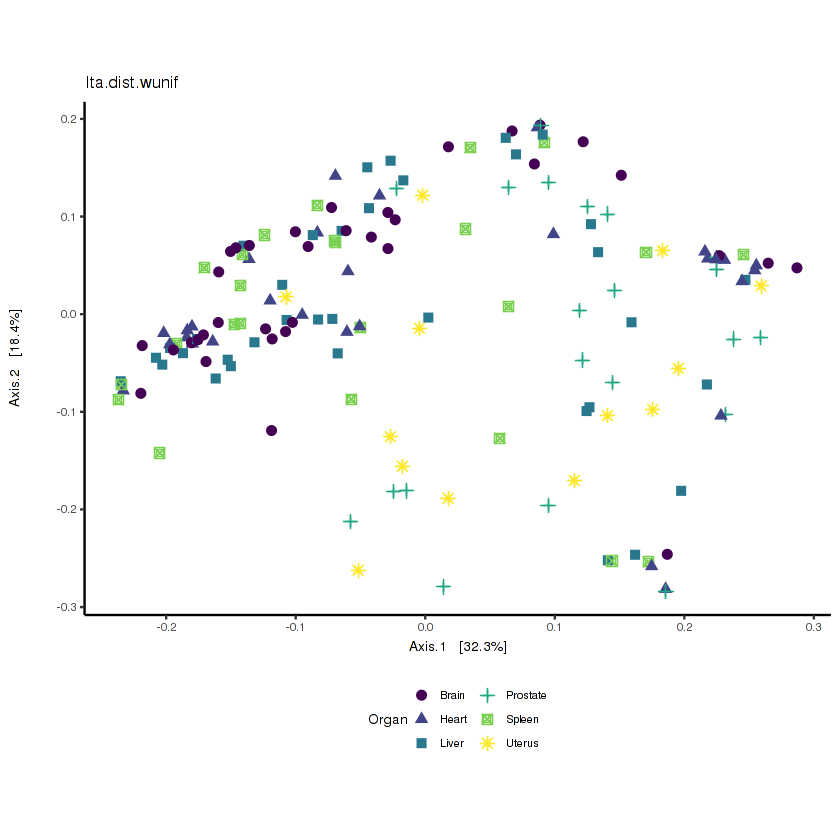

In [11]:
Ita.dist.wunif.log = ordinate(Ita, method = "PCoA", distance = "wunifrac")
Ita.dist.wunif.evals = Ita.dist.wunif.log$values$Eigenvalues
p = plot_ordination(Ita, Ita.dist.wunif.log, color = "Organ", shape = "Organ") + 
    ggtitle("Ita.dist.wunif") + 
    geom_point(size=2.5) +#, alpha=0.4) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Sex), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(Ita.dist.wunif.evals[2] / Ita.dist.wunif.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_classic() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p

#png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/Bdiv/PCoA_MOD.faceted.wunif.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

In [13]:
p$layers

[[1]]
geom_point: na.rm = TRUE
stat_identity: na.rm = TRUE
position_identity 

[[2]]
geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 


Warning message in UniFrac(physeq, ...):
“Randomly assigning root as -- TACGTAGGTGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTGCGTAGGTGGCAGAACAAGTCTGGAGTAAAAGGTATGGGCTCAACCCGTACTGGCTCTGGAAACTGTTCAGCTAGAGAACAGAAGAGGACGGCGGAACTCCATGT -- in the phylogenetic tree in the data you provided.”

png 
  2

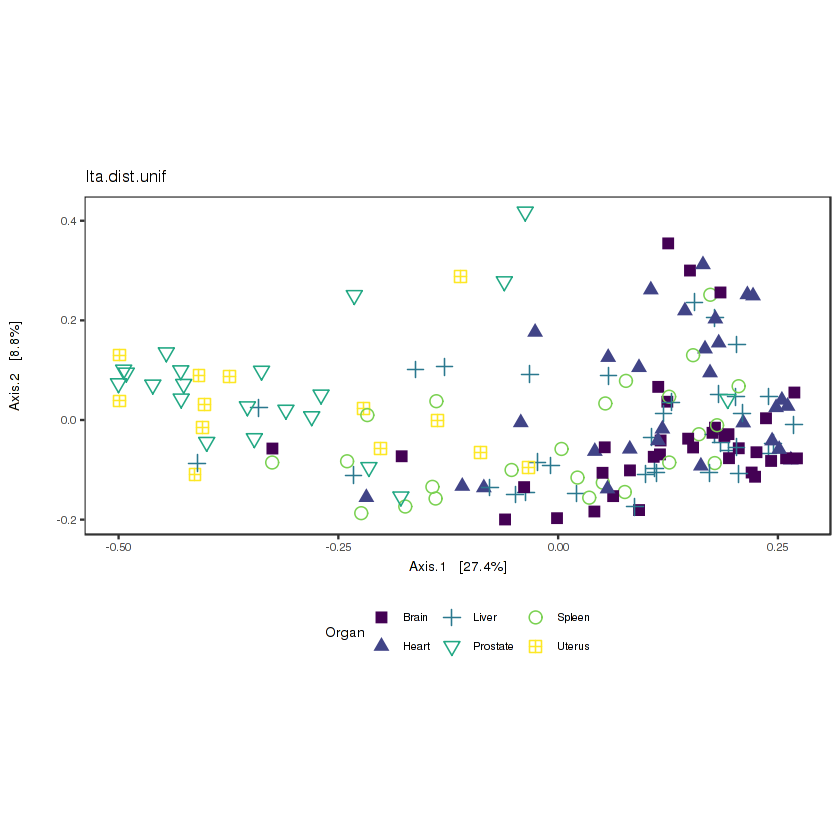

In [16]:
Ita.dist.unif.log = ordinate(Ita, method = "PCoA", distance = "unifrac")
Ita.dist.unif.evals = Ita.dist.unif.log$values$Eigenvalues
p = plot_ordination(Ita, Ita.dist.unif.log, color="Organ", shape="Organ") + 
    geom_point(size=3) +
    scale_shape_manual(values=c(15,17,3,6,1,12)) +
    ggtitle("Ita.dist.unif") + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=TRUE, direction=1)+
    coord_fixed(sqrt(Ita.dist.unif.evals[2] / Ita.dist.unif.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")

p$layers <- p$layers[-1]

p

png('PCoA_organs.unif.png', width=6, height=5, units='in', res=300)
plot(p)
dev.off()

In [23]:
p$layer

[[1]]
geom_point: na.rm = TRUE
stat_identity: na.rm = TRUE
position_identity 

[[2]]
geom_point: na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 


Warning message in MASS::cov.trob(data[, vars]):
“Probable convergence failure”

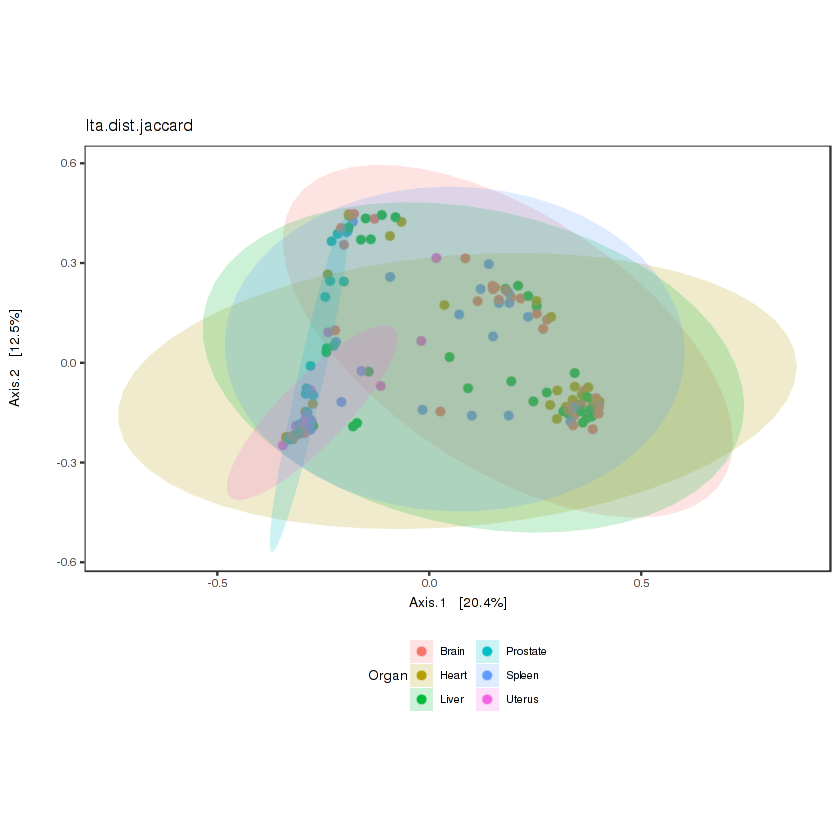

In [12]:
Ita.dist.jaccard.log = ordinate(Ita, method = "PCoA", distance = "jaccard")
Ita.dist.jaccard.evals = Ita.dist.jaccard.log$values$Eigenvalues
p = plot_ordination(Ita, Ita.dist.jaccard.log, color = "Organ") + 
    ggtitle("Ita.dist.jaccard") + 
    geom_point(size=2, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    #scale_colour_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    #scale_fill_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    coord_fixed(sqrt(Ita.dist.jaccard.evals[2] / Ita.dist.jaccard.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p

#png('PCoA_fecal_diet.jaccard.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

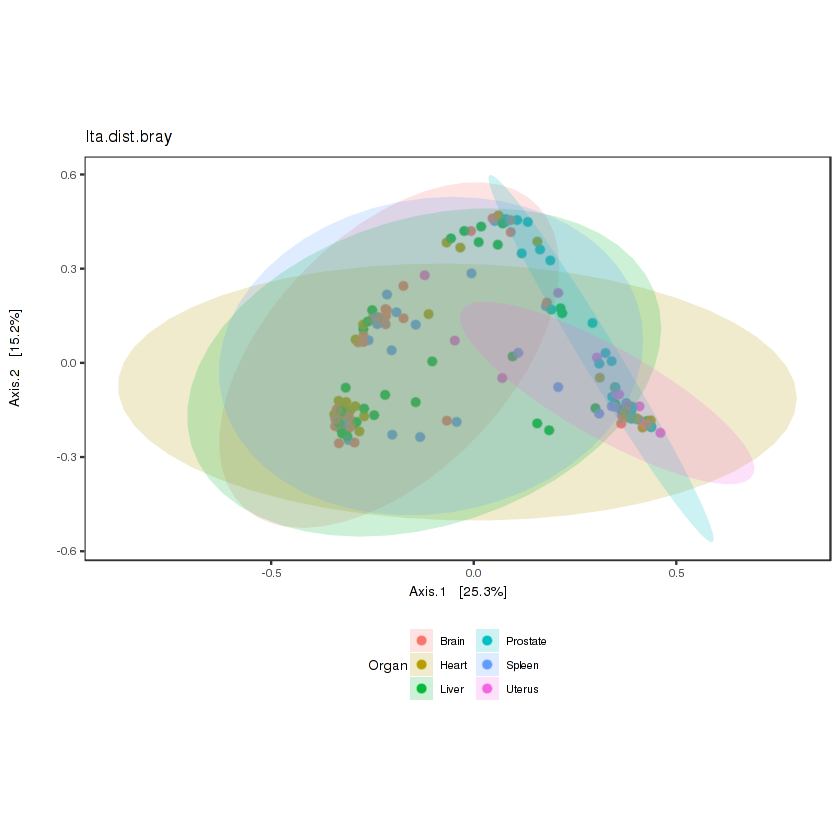

In [13]:
Ita.dist.bray.log = ordinate(Ita, method = "PCoA", distance = "bray")
Ita.dist.bray.evals = Ita.dist.bray.log$values$Eigenvalues
p = plot_ordination(Ita, Ita.dist.bray.log, color = "Organ") + 
    ggtitle("Ita.dist.bray") + 
    geom_point(size=2, alpha=0.4) + 
    #scale_colour_brewer(palette='BrBG') +
    #scale_colour_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = Organ), linetype=0) +
    #scale_fill_brewer(palette='BrBG')+
    #scale_fill_manual(values=c("#885122", #Finland
    #                             "#35938B", #Italy
    #                             "#77933C")) + #USA
    coord_fixed(sqrt(Ita.dist.bray.evals[2] / Ita.dist.bray.evals[1]))

p = p + guides(colour = guide_legend(title = "Organ", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_bw() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              #legend.key.size = unit(.1, "in"),
              #legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom")


p

#png('PCoA_fecal_diet.bray.png', width=6, height=5, units='in', res=300)
#plot(p)
#dev.off()

### Rank Abundance

In [120]:
Ita.nt = subset_samples(cadaver_nt, Location=="Italy")
#Ita.df = data.frame(sample_data(Ita))

Ita.nt.mdf = psmelt(Ita.nt)
#Ita.mdf = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Ita_t.mdf.csv")

In [125]:
avg(Ita.nt.mdf$Abundance)

ERROR: Error in avg(Ita.nt.mdf$Abundance): could not find function "avg"


In [102]:
#Replace variable manners of death with correct category
Ita.mdf$The_manner_of_death = as.character(Ita.mdf$The_manner_of_death)
Ita.mdf$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Accident_road traffic accident'] <- 'Accident'
Ita.mdf$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Accident_Road traffic accident'] <- 'Accident'
Ita.mdf$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Accident_Work related accident'] <- 'Accident'
Ita.mdf$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Natural death'] <- 'Natural'
Ita.mdf$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Undetermined'] <- 'Natural'
Ita.mdf$The_manner_of_death = as.factor(Ita.mdf$The_manner_of_death)
head(Ita.mdf$The_manner_of_death)

[1] Natural  Suicide  Accident Natural  Suicide  Natural 
Levels: Accident Homicide Natural Suicide

In [26]:
Ita.mdf.2 = Ita.mdf
Ita.mdf.2$The_manner_of_death = as.character(Ita.mdf.2$The_manner_of_death)
Ita.mdf.2$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Accident'] <- 'Unnatural'
Ita.mdf.2$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Homicide'] <- 'Unnatural'
Ita.mdf.2$The_manner_of_death[Ita.mdf$The_manner_of_death == 'Suicide'] <- 'Unnatural'
Ita.mdf.2$The_manner_of_death = as.factor(Ita.mdf.2$The_manner_of_death)
head(Ita.mdf.2$The_manner_of_death)

[1] Natural   Unnatural Unnatural Natural   Unnatural Natural  
Levels: Natural Unnatural

In [103]:
Ita = Ita.mdf %>%
mutate(PMI_cat = PMI)

Ita$PMI_cat = as.character(Ita$PMI_cat)
Ita$PMI_cat[which(Ita$PMI_cat =="24")] = "A24hr"
Ita$PMI_cat[which(Ita$PMI_cat =="32")] = "B48hr"
Ita$PMI_cat[which(Ita$PMI_cat =="36")] = "B48hr"
Ita$PMI_cat[which(Ita$PMI_cat =="38")] = "B48hr"
Ita$PMI_cat[which(Ita$PMI_cat =="42")] = "B48hr"
Ita$PMI_cat[which(Ita$PMI_cat =="48")] = "B48hr"

Ita$PMI_cat[which(Ita$PMI_cat =="60")] = "C72hr"
Ita$PMI_cat[which(Ita$PMI_cat =="65")] = "C72hr"
Ita$PMI_cat[which(Ita$PMI_cat =="72")] = "C72hr"

Ita$PMI_cat[which(Ita$PMI_cat =="77")] = "D96hr"
Ita$PMI_cat[which(Ita$PMI_cat =="96")] = "D96hr"

Ita$PMI_cat[which(Ita$PMI_cat =="108")] = "E120hr"
Ita$PMI_cat[which(Ita$PMI_cat =="120")] = "E120hr"

Ita$PMI_cat[which(Ita$PMI_cat =="144")] = "F144hr"

Ita$PMI_cat[which(Ita$PMI_cat =="168")] = "G168hr"
Ita$PMI_cat[which(Ita$PMI_cat =="180")] = "H190hr"
Ita$PMI_cat[which(Ita$PMI_cat =="240")] = "I240hr" #10day
Ita$PMI_cat[which(Ita$PMI_cat =="336")] = "J336hr" #14day
Ita$PMI_cat[which(Ita$PMI_cat =="360")] = "K360hr" #15day
Ita$PMI_cat[which(Ita$PMI_cat =="432")] = "J336hr" #18day
Ita$PMI_cat = as.factor(Ita$PMI_cat)
head(Ita$PMI_cat)

[1] K360hr I240hr B48hr  C72hr  I240hr E120hr
11 Levels: A24hr B48hr C72hr D96hr E120hr F144hr G168hr H190hr ... K360hr

In [33]:
colnames(Ita)

[1] "X"                    "OTU"                  "Sample"              
 [4] "Abundance"            "X.SampleID"           "BarcodeSequence"     
 [7] "LinkerPrimerSequence" "RTL_run"              "Case_no"             
[10] "Sex"                  "Age"                  "Ethnicity"           
[13] "Order"                "Location"             "PMI"                 
[16] "Organ"                "RTLID"                "Samplename"          
[19] "Cause_of_death"       "The_manner_of_death"  "Height_cm"           
[22] "Weight_kg"            "bmi"                  "bmi_category"        
[25] "Description"          "Rank1"                "Rank2"               
[28] "Rank3"                "Rank4"                "Rank5"               
[31] "Rank6"                "Rank7"                "PMI_cat"

In [104]:
N = 4

topN = Ita %>%
    group_by(Rank4) %>%
    summarize(Abundance = sum(Abundance)) %>%
    group_by(Rank4) %>%
    summarize(m = mean(Abundance)) %>%
    top_n(N) %>%
    arrange(desc(m)) %>%
    magrittr::extract2("Rank4")

mdfall.other = Ita %>%
    mutate(Rank4.other = ifelse(Rank4 %in% topN, as.character(Rank4), "Other")) %>%
    group_by(Rank4.other,The_manner_of_death,Organ,PMI) %>%
    summarize(Abundance = sum(Abundance)) %>%
    arrange(Abundance)

mdfall.summary = mdfall.other %>%
    group_by(Rank4.other,The_manner_of_death,Organ,PMI) %>%
    summarise(avg = mean(Abundance), 
              sd = sd(Abundance), 
              sem = sd/sqrt(length(Abundance)),
              proportion = round(avg*100,2)) %>%
    arrange((Rank4.other))

mdfall.other$Rank4.other = as.character(mdfall.other$Rank4.other)
mdfall.other$Rank4.other[which(mdfall.other$Rank4.other == "o__")] <- "Other"
head(as.factor(mdfall.other$Rank4.other))

mdfall.summary$Rank4.other = as.character(mdfall.summary$Rank4.other)
mdfall.summary$Rank4.other[which(mdfall.summary$Rank4.other == "o__")] <- "Other"

mdfall.other = subset(mdfall.other, Rank4.other!="Other")
head(as.factor(mdfall.other$Rank4.other))

#write.csv(mdfall.summary, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/Rank4_mdfall.summary.csv")

Selecting by m


[1] o__Burkholderiales o__Burkholderiales o__Burkholderiales o__Burkholderiales
[5] o__Clostridiales   o__Clostridiales  
5 Levels: o__Burkholderiales o__Clostridiales ... Other

[1] o__Burkholderiales o__Burkholderiales o__Burkholderiales o__Burkholderiales
[5] o__Clostridiales   o__Clostridiales  
4 Levels: o__Burkholderiales o__Clostridiales ... o__[Saprospirales]

In [105]:
mdfall.other.2$The_manner_of_death = as.character(mdfall.other.2$The_manner_of_death)
mdfall.other.2 = subset(mdfall.other.2, PMI<73)
mdfall.other.2.nat = subset(mdfall.other.2, The_manner_of_death=="Natural")
mdfall.other.2.acc = subset(mdfall.other.2, The_manner_of_death=="Accident")
mdfall.other.2.hom = subset(mdfall.other.2, The_manner_of_death=="Homicide")
mdfall.other.2.sui = subset(mdfall.other.2, The_manner_of_death=="Suicide")


In [114]:
#x = summarize(mdfall.other$PMI))
mdfall.other %>%
group_by() %>%
summarise(avg = mean(PMI), 
              sd = sd(PMI), 
              sem = sd/sqrt(length(PMI)))

avg,sd,sem
116.1642,102.72,4.436826


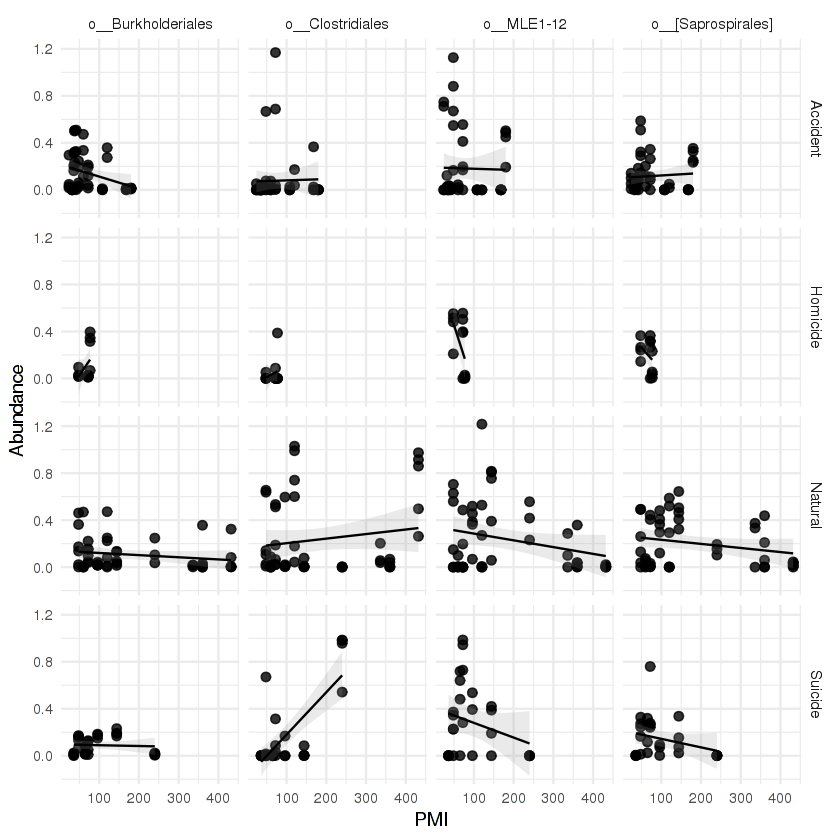

In [108]:
p = ggplot(mdfall.other, aes(x=PMI, y=Abundance)) + geom_point(size = 2, alpha = .8)
p = p + geom_smooth(method = "lm", se=TRUE, alpha=.2, color="black", size=0.5) + 
        theme_minimal() + theme(plot.title = element_text(hjust = 2))
#p = p + facet_wrap(~Rank4.other)
p = p + facet_grid(The_manner_of_death~Rank4.other)
p

#png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/Bdiv/MOD.nat_v_unnat_by_PMI_toporders.png', width=8, height=6, units='in', res=300)
#plot(p)
#dev.off()

In [55]:
Accident = subset(mdfall.other, The_manner_of_death=="Accident")
Accident.burk = subset(Accident, Rank4.other=="o__Burkholderiales")
Accident.clost = subset(Accident, Rank4.other=="o__Clostridiales")
Accident.mle = subset(Accident, Rank4.other=="o__MLE1-12")
Accident.sap = subset(Accident, Rank4.other=="o__[Saprospirales]")

In [56]:
fit = lm(Abundance ~ PMI, data = Accident.burk)
anova(fit)
summary(fit)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
PMI,1,0.1319614,0.13196136,5.435588,0.02448543
Residuals,43,1.0439235,0.02427729,NA,NA



Call:
lm(formula = Abundance ~ PMI, data = Accident.burk)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18362 -0.12667 -0.02371  0.07868  0.33582 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.2167669  0.0406732   5.329 3.42e-06 ***
PMI         -0.0010358  0.0004443  -2.331   0.0245 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1558 on 43 degrees of freedom
Multiple R-squared:  0.1122,	Adjusted R-squared:  0.09158 
F-statistic: 5.436 on 1 and 43 DF,  p-value: 0.02449


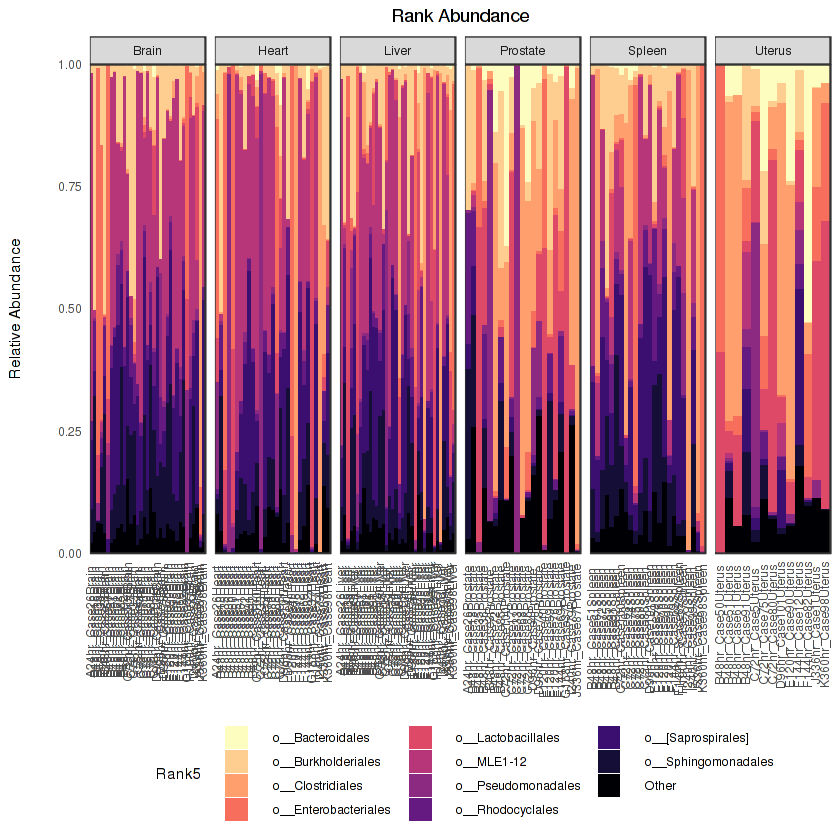

In [170]:
p = ggplot(mdfall.other[order(mdfall.other$Rank4.other),], aes(x=Sample2, y = Abundance, fill = Rank4.other))
                        
p = p + facet_wrap(~Organ, shrink = TRUE, scales = "free_x",nrow=1) +
    ylab("Relative Abundance")  +
    geom_bar(stat="identity") +
    scale_fill_viridis(option="magma", discrete=TRUE, direction=-1) +
    scale_y_continuous(expand = c(0,0))

p = p + guides(fill = guide_legend(title = "Rank5", nrow = 4, keywidth = 1, keyheight = 1))

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=9, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              legend.spacing.x = unit(.2,"in"),
              axis.title.x=element_blank())

p = p + theme(legend.position="bottom") 

p = p + ggtitle("Rank Abundance") + theme(plot.title = element_text(hjust = 0.5))

p

In [41]:
mdfall.other$Rank4.other = as.character(mdfall.other$Rank4.other)
mdfall.other$Rank4.other[which(mdfall.other$Rank4.other == "o__")] <- "Other"
head(as.factor(mdfall.other$Rank4.other))

[1] o__MLE1-12         Other              o__Bacteroidales   o__Rhizobiales    
[5] o__Caulobacterales o__Bacteroidales  
13 Levels: o__Bacteroidales o__Burkholderiales ... Other

In [17]:
write.csv(mdfall.other, "/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/Top12Order.Organ.temp.csv")

png 
  2

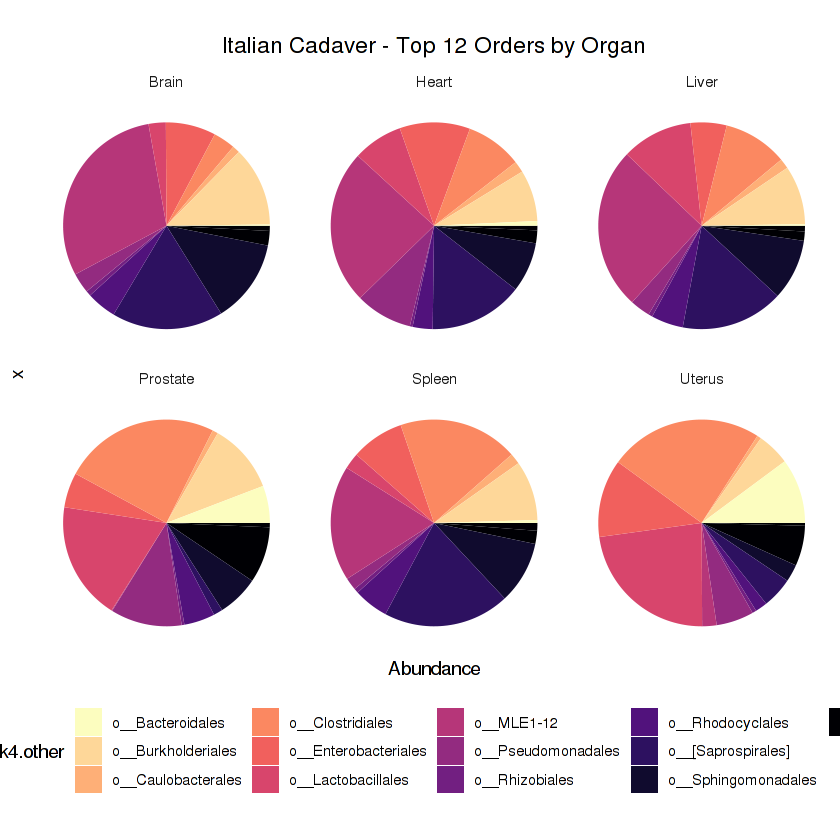

In [14]:
#PLOT RELATIVE ABUNDANCE OF BACTERIAL FAMILY FACETED BY HOST FAMILY

p <- ggplot(mdfall.other, aes(x="", y=Abundance, fill=Rank4.other)) +
geom_bar(stat = "identity", width = 1, position = "fill") +
coord_polar("y", start=pi/2) + 
labs(title="Italian Cadaver - Top 12 Orders by Organ")
p = p + scale_fill_viridis(option="magma", discrete=TRUE, direction=-1)
p = p + theme_minimal() + theme(legend.position="bottom", 
                                  plot.title = element_text(hjust = 0.5),
                                  axis.text = element_blank(),
                                  axis.ticks = element_blank(),
                                  panel.grid  = element_blank())

p  = p + facet_wrap( ~Organ, shrink = TRUE)

p

png('Piechart_Top13Order.png', width=10, height=5, units='in', res=300)
plot(p)
dev.off()

### ANCOM

In [23]:
#Ita = prune_samples(sample_sums(Ita)>0, Ita)
#Ita.otu = data.frame(otu_table(Ita))
Ita.otu = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/ANCOM/Ita.otu.csv")
#Ita.meta = data.frame(sample_data(Ita))
Ita.meta = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/ANCOM/Ita.meta.csv")

In [38]:
Ita.taxa.csv = data.frame(tax_table(Ita))
write.csv(Ita.taxa.csv, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/ANCOM/Ita.taxa.csv")

In [34]:
#Group into uterus vs all other organs
Ita = Ita.meta %>%
mutate(Single_Organ = Organ)

Ita$Single_Organ = as.character(Ita$Single_Organ)
Ita$Single_Organ[which(Ita$Organ != "Uterus")] = "Other"
Ita$Single_Organ = as.factor(Ita$Single_Organ)
head(Ita$Single_Organ)

#RUN ANCOM

comparison_test=ANCOM.main(OTUdat=Ita.otu,
                           Vardat=Ita,
                           adjusted=TRUE,
                           repeated=F,
                           main.var="Single_Organ",
                           adj.formula="Sex+Age+PMI+bmi_category+The_manner_of_death", #covariates
                           repeat.var=NULL,
                           longitudinal=FALSE,
                           random.formula=NULL,
                           multcorr=2, #2 corresponds to BH FDR correction
                           sig=0.05,
                           prev.cut=0.90)

Ita.byorgan.ancom = comparison_test$W.taxa

write.csv(Ita.byorgan.ancom, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/ANCOM/uterus.ancom.csv")

[1] Other Other Other Other Other Other
Levels: Other Uterus

In [61]:
spleen = Ita.meta %>%
mutate(Single_Organ = Organ)

spleen$Single_Organ = as.character(spleen$Single_Organ)
spleen$Single_Organ[which(spleen$Organ != "Spleen")] = "Other"
spleen$Single_Organ = as.factor(spleen$Single_Organ)
head(spleen$Single_Organ)

[1] Other  Other  Other  Other  Spleen Other 
Levels: Other Spleen

In [62]:
write.csv(brain, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/brain.meta.csv")
write.csv(heart, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/heart.meta.csv")
write.csv(liver, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/liver.meta.csv")
write.csv(spleen, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/spleen.meta.csv")
write.csv(prostate, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/prostate.meta.csv")
write.csv(uterus, "/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/uterus.meta.csv")

In [77]:
#Read metadata in/out to convert to mapfile for new ps object (retaining Single_Organ column)
library(DESeq2)

brain.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/brain.meta.txt")
heart.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/heart.meta.txt")
liver.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/liver.meta.txt")
spleen.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/spleen.meta.txt")
prostate.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/prostate.meta.txt")
uterus.map = import_qiime_sample_data("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/uterus.meta.txt")

cadaver_nt = readRDS("/gpfs/data/gilbert-lab/Lutz/Cadaver/All_cohorts/RDSfiles/all_cohorts_cadaver_nt.rds")
#Subset to Italian data only
Ita = subset_samples(cadaver_nt, Location=="Italy")

#create new ps objects 

tree = phy_tree(Ita)
otu = otu_table(Ita)
tax = tax_table(Ita)

brain.ps = merge_phyloseq(brain.map, tree, otu, tax)
heart.ps = merge_phyloseq(heart.map, tree, otu, tax)
liver.ps = merge_phyloseq(liver.map, tree, otu, tax)
spleen.ps = merge_phyloseq(spleen.map, tree, otu, tax)
prostate.ps = merge_phyloseq(prostate.map, tree, otu, tax)
uterus.ps = merge_phyloseq(uterus.map, tree, otu, tax)


In [78]:
#convert ps to deseq object

brain_dds = phyloseq_to_deseq2(brain.ps, ~Single_Organ)
heart_dds = phyloseq_to_deseq2(heart.ps, ~Single_Organ)
liver_dds = phyloseq_to_deseq2(liver.ps, ~Single_Organ)
spleen_dds = phyloseq_to_deseq2(spleen.ps, ~Single_Organ)
prostate_dds = phyloseq_to_deseq2(prostate.ps, ~Single_Organ)
uterus_dds = phyloseq_to_deseq2(uterus.ps, ~Single_Organ)

converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode
converting counts to integer mode


In [80]:
#Run DESeq - brain 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(brain_dds), 1, gm_mean)


brain_dds = estimateSizeFactors(brain_dds, geoMeans = geoMeans)
brain_dds = estimateDispersions(brain_dds)
abund = getVarianceStabilizedData(brain_dds)

brain_dds = DESeq(brain_dds, test="Wald", fitType="parametric")

res = results(brain_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(brain.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/brain.deseq.log2fold.csv")


###################################################################################################
#Run DESeq - heart 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(heart_dds), 1, gm_mean)


heart_dds = estimateSizeFactors(heart_dds, geoMeans = geoMeans)
heart_dds = estimateDispersions(heart_dds)
abund = getVarianceStabilizedData(heart_dds)

heart_dds = DESeq(heart_dds, test="Wald", fitType="parametric")

res = results(heart_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(heart.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/heart.deseq.log2fold.csv")

###################################################################################################
#Run DESeq - liver 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(liver_dds), 1, gm_mean)


liver_dds = estimateSizeFactors(liver_dds, geoMeans = geoMeans)
liver_dds = estimateDispersions(liver_dds)
abund = getVarianceStabilizedData(liver_dds)

liver_dds = DESeq(liver_dds, test="Wald", fitType="parametric")

res = results(liver_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(liver.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/liver.deseq.log2fold.csv")


###################################################################################################
#Run DESeq - spleen 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(spleen_dds), 1, gm_mean)


spleen_dds = estimateSizeFactors(spleen_dds, geoMeans = geoMeans)
spleen_dds = estimateDispersions(spleen_dds)
abund = getVarianceStabilizedData(spleen_dds)

spleen_dds = DESeq(spleen_dds, test="Wald", fitType="parametric")

res = results(spleen_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(spleen.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/spleen.deseq.log2fold.csv")


###################################################################################################
#Run DESeq - prostate 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(prostate_dds), 1, gm_mean)


prostate_dds = estimateSizeFactors(prostate_dds, geoMeans = geoMeans)
prostate_dds = estimateDispersions(prostate_dds)
abund = getVarianceStabilizedData(prostate_dds)

prostate_dds = DESeq(prostate_dds, test="Wald", fitType="parametric")

res = results(prostate_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(prostate.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/prostate.deseq.log2fold.csv")


###################################################################################################
#Run DESeq - uterus 

gm_mean = function(x, na.rm=TRUE){
  exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
}

geoMeans = apply(DESeq2::counts(uterus_dds), 1, gm_mean)


uterus_dds = estimateSizeFactors(uterus_dds, geoMeans = geoMeans)
uterus_dds = estimateDispersions(uterus_dds)
abund = getVarianceStabilizedData(uterus_dds)

uterus_dds = DESeq(uterus_dds, test="Wald", fitType="parametric")

res = results(uterus_dds)
res.tax = cbind(as(res, "data.frame"), as(tax_table(uterus.ps)[rownames(res), ], "matrix"))

write.csv(res.tax, file="/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/DESEQ/uterus.deseq.log2fold.csv")


found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 322 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 315 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in 

In [46]:
ancom_0.60.org = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/ANCOM/organs.ancom.csv")

png 
  2

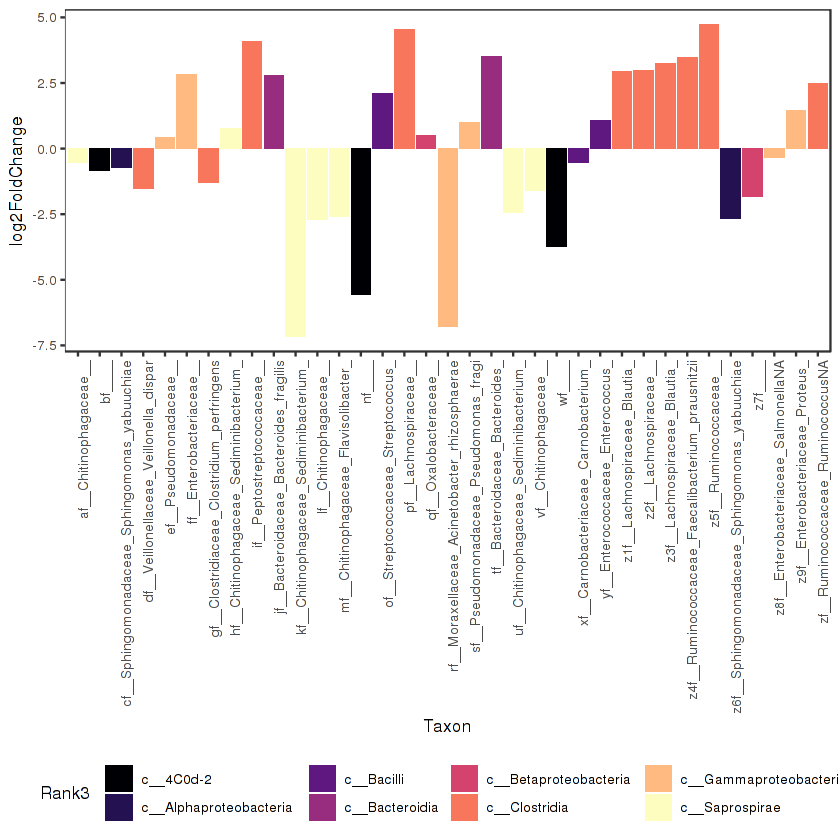

In [47]:
library(viridis)
p = ggplot(ancom_0.60.org, aes(x = Taxon, y = log2FoldChange, fill=Rank3)) + geom_bar(stat="identity")

p = p + scale_fill_viridis(option="magma", discrete=TRUE, direction=1)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())

p



png('Organs_ANCOM_0.60_log2foldchange.magma.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

In [19]:
library(exactRankTests)
library(nlme)
library(ggplot2)

ancom.W = function(otu_data,var_data,
                   adjusted,repeated,
                   main.var,adj.formula,
                   repeat.var,long,rand.formula,
                   multcorr,sig){
  
  n_otu=dim(otu_data)[2]-1
  
  otu_ids=colnames(otu_data)[-1]
  
  if(repeated==F){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID",all.y=T),row.names=NULL)
    #data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var)],by="Sample.ID",all.y=T),row.names=NULL)
  }else if(repeated==T){
    data_comp=data.frame(merge(otu_data,var_data,by="Sample.ID"),row.names=NULL)
   # data_comp=data.frame(merge(otu_data,var_data[,c("Sample.ID",main.var,repeat.var)],by="Sample.ID"),row.names=NULL)
  }
  
  base.formula = paste0("lr ~ ",main.var)
  if(repeated==T){
    repeat.formula = paste0(base.formula," | ", repeat.var)
  }
  if(adjusted==T){
    adjusted.formula = paste0(base.formula," + ", adj.formula)
  }
  
  if( adjusted == F & repeated == F ){
    fformula  <- formula(base.formula)
  } else if( adjusted == F & repeated == T & long == T ){
    fformula  <- formula(base.formula)   
  }else if( adjusted == F & repeated == T & long == F ){
    fformula  <- formula(repeat.formula)   
  }else if( adjusted == T & repeated == F  ){
    fformula  <- formula(adjusted.formula)   
  }else if( adjusted == T & repeated == T  ){
    fformula  <- formula(adjusted.formula)   
  }else{
    stop("Problem with data. Dataset should contain OTU abundances, groups, 
         and optionally an ID for repeated measures.")
  }
  
  
  
    if( repeated==FALSE & adjusted == FALSE){
       if( length(unique(data_comp[,which(colnames(data_comp)==main.var)]))==2 ){
          tfun <- exactRankTests::wilcox.exact
       } else{
          tfun <- stats::kruskal.test
    }
    }else if( repeated==FALSE & adjusted == TRUE){
      tfun <- stats::aov
    }else if( repeated== TRUE & adjusted == FALSE & long == FALSE){
      tfun <- stats::friedman.test
    }else if( repeated== TRUE & adjusted == FALSE & long == TRUE){
      tfun <- nlme::lme
    }else if( repeated== TRUE & adjusted == TRUE){
      tfun <- nlme::lme
    }
  
  logratio.mat <- matrix(NA, nrow=n_otu, ncol=n_otu)
  for(ii in 1:(n_otu-1)){
    for(jj in (ii+1):n_otu){
      data.pair <- data_comp[,which(colnames(data_comp)%in%otu_ids[c(ii,jj)])]
      lr <- log((1+as.numeric(data.pair[,1]))/(1+as.numeric(data.pair[,2])))
      
      lr_dat <- data.frame( lr=lr, data_comp,row.names=NULL )
      
      if(adjusted==FALSE&repeated==FALSE){  ## Wilcox, Kruskal Wallis
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==FALSE&repeated==TRUE&long==FALSE){ ## Friedman's 
        logratio.mat[ii,jj] <- tfun( formula=fformula, data = lr_dat)$p.value
      }else if(adjusted==TRUE&repeated==FALSE){ ## ANOVA
        model=tfun(formula=fformula, data = lr_dat,na.action=na.omit)   
        picker=which(gsub(" ","",row.names(summary(model)[[1]]))==main.var)  
        logratio.mat[ii,jj] <- summary(model)[[1]][["Pr(>F)"]][picker]
      }else if(repeated==TRUE&long==TRUE){ ## GEE
        model=tfun(fixed=fformula,data = lr_dat,
                   random = formula(rand.formula),
                   correlation=corAR1(),
                   na.action=na.omit)   
        picker=which(gsub(" ","",row.names(anova(model)))==main.var)
        logratio.mat[ii,jj] <- anova(model)[["p-value"]][picker]
      }
      
    }
  } 
  
  ind <- lower.tri(logratio.mat)
  logratio.mat[ind] <- t(logratio.mat)[ind]
  
  
  logratio.mat[which(is.finite(logratio.mat)==FALSE)] <- 1
  
  mc.pval <- t(apply(logratio.mat,1,function(x){
    s <- p.adjust(x, method = "BH")
    return(s)
  }))
  
  a <- logratio.mat[upper.tri(logratio.mat,diag=FALSE)==TRUE]
  
  b <- matrix(0,ncol=n_otu,nrow=n_otu)
  b[upper.tri(b)==T] <- p.adjust(a, method = "BH")
  diag(b)  <- NA
  ind.1    <- lower.tri(b)
  b[ind.1] <- t(b)[ind.1]
  
  #########################################
  ### Code to extract surrogate p-value
  surr.pval <- apply(mc.pval,1,function(x){
    s0=quantile(x[which(as.numeric(as.character(x))<sig)],0.95)
    # s0=max(x[which(as.numeric(as.character(x))<alpha)])
    return(s0)
  })
  #########################################
  ### Conservative
  if(multcorr==1){
    W <- apply(b,1,function(x){
      subp <- length(which(x<sig))
    })
    ### Moderate
  } else if(multcorr==2){
    W <- apply(mc.pval,1,function(x){
      subp <- length(which(x<sig))
    })
    ### No correction
  } else if(multcorr==3){
    W <- apply(logratio.mat,1,function(x){
      subp <- length(which(x<sig))
    })
  }
  
  return(W)
  }



ANCOM.main = function(OTUdat,Vardat,
                      adjusted,repeated,
                      main.var,adj.formula,
                      repeat.var,longitudinal,
                      random.formula,
                      multcorr,sig,
                      prev.cut){
  
  p.zeroes=apply(OTUdat[,-1],2,function(x){
    s=length(which(x==0))/length(x)
  })
  
  zeroes.dist=data.frame(colnames(OTUdat)[-1],p.zeroes,row.names=NULL)
  colnames(zeroes.dist)=c("Taxon","Proportion_zero")
  
  zero.plot = ggplot(zeroes.dist, aes(x=Proportion_zero)) + 
              geom_histogram(binwidth=0.1,colour="black",fill="white") + 
              xlab("Proportion of zeroes") + ylab("Number of taxa") +
              theme_bw()
  
  #print(zero.plot)
  
  OTUdat.thinned=OTUdat
  OTUdat.thinned=OTUdat.thinned[,c(1,1+which(p.zeroes<prev.cut))]
  
  otu.names=colnames(OTUdat.thinned)[-1]
  
  W.detected   <- ancom.W(OTUdat.thinned,Vardat,
                          adjusted,repeated,
                          main.var,adj.formula,
                          repeat.var,longitudinal,random.formula,
                          multcorr,sig)
  
  W_stat       <- W.detected
  
  
  ### Bubble plot
  
  W_frame = data.frame(otu.names,W_stat,row.names=NULL)
  W_frame = W_frame[order(-W_frame$W_stat),]
  
  W_frame$detected_0.9=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.8=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.7=rep(FALSE,dim(W_frame)[1])
  W_frame$detected_0.6=rep(FALSE,dim(W_frame)[1])
  
  W_frame$detected_0.9[which(W_frame$W_stat>0.9*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.8[which(W_frame$W_stat>0.8*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.7[which(W_frame$W_stat>0.7*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  W_frame$detected_0.6[which(W_frame$W_stat>0.6*(dim(OTUdat.thinned[,-1])[2]-1))]=TRUE
  
  final_results=list(W_frame,zero.plot)
  names(final_results)=c("W.taxa","PLot.zeroes")
  return(final_results)
    }

 Package ‘exactRankTests’ is no longer under development.
 Please consider using package ‘coin’ instead.


Attaching package: ‘nlme’

The following object is masked from ‘package:dplyr’:

    collapse



In [ ]:
### Line charts of bacterial changes v PMI

In [59]:
rank2sum = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/Rank2_mdfall.summary.csv")
rank5sum = read.csv("/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/Rank5_mdfall.summary.csv")

rank2sum = subset(rank2sum, Phylum.other!="Other")

brain = subset(rank2sum, Organ=="Brain")
heart = subset(rank2sum, Organ=="Heart")
liver = subset(rank2sum, Organ=="Liver")
spleen = subset(rank2sum, Organ=="Spleen")
prostate = subset(rank2sum, Organ=="Prostate")
uterus = subset(rank2sum, Organ=="Uterus")

In [18]:
head(rank4sum)

X,PMI_cat,Rank4.other,Organ,avg,sd,sem,proportion
490,a_24,o__[Saprospirales],Brain,0.14184837,NA,NA,14.18
26,a_24,o__Bacteroidales,Brain,0.00000000,NA,NA,0.00
84,a_24,o__Burkholderiales,Brain,0.01697225,NA,NA,1.70
142,a_24,o__Clostridiales,Brain,0.00000000,NA,NA,0.00
200,a_24,o__Enterobacteriales,Brain,0.00000000,NA,NA,0.00
258,a_24,o__Lactobacillales,Brain,0.00000000,NA,NA,0.00


png 
  2

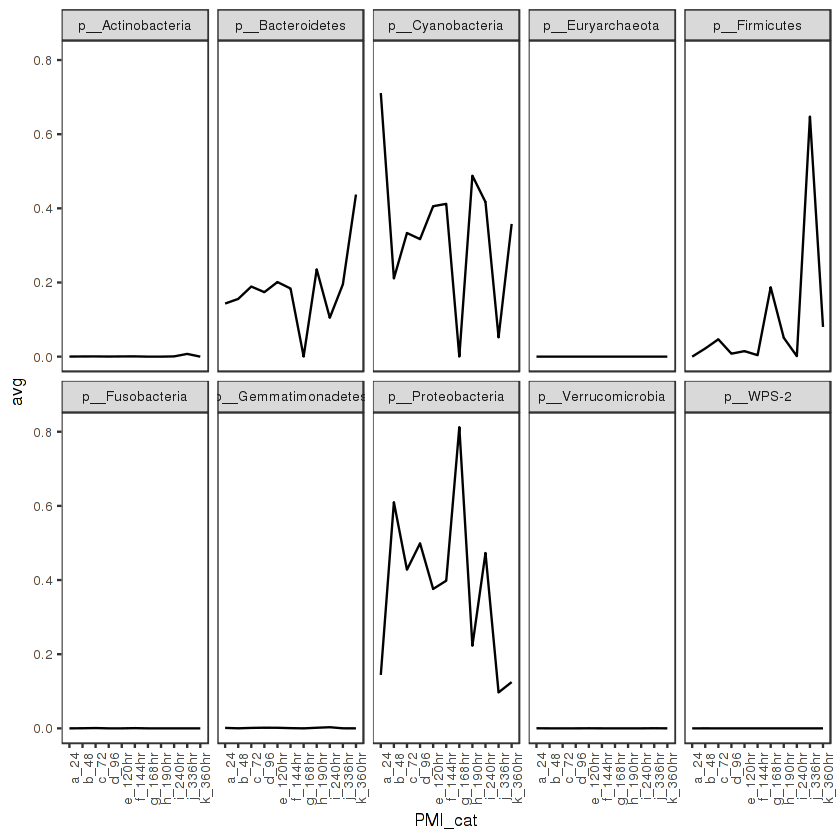

In [60]:
# Basic line plot with points
p = ggplot(data=brain, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.brain.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

png 
  2

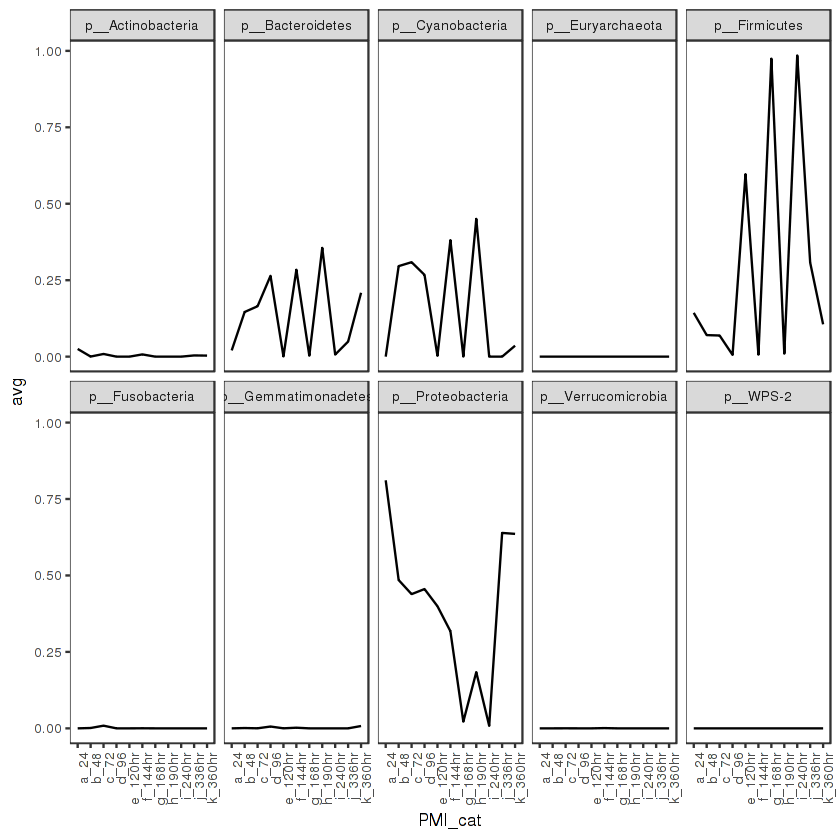

In [61]:
# Basic line plot with points
p = ggplot(data=heart, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.heart.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

png 
  2

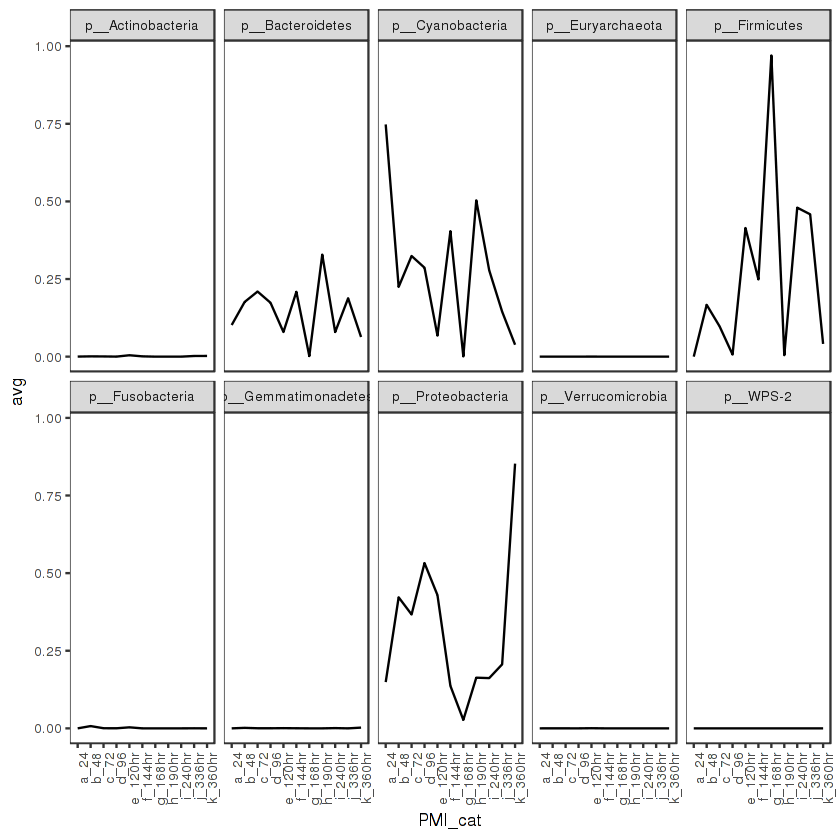

In [62]:
# Basic line plot with points
p = ggplot(data=liver, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.liver.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

png 
  2

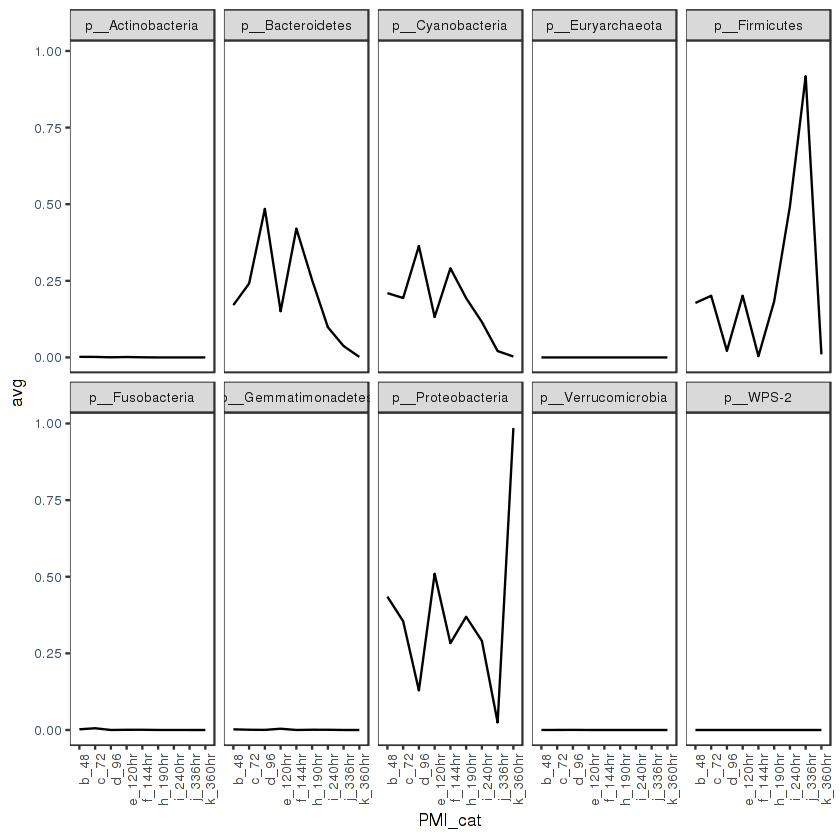

In [63]:
# Basic line plot with points
p = ggplot(data=spleen, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.spleen.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

png 
  2

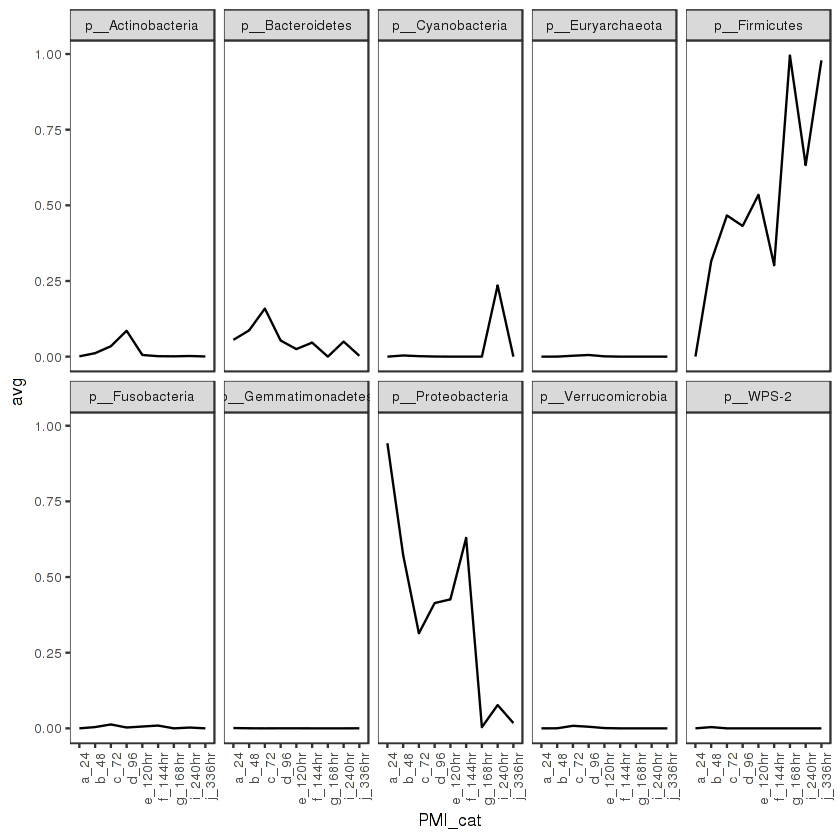

In [64]:
# Basic line plot with points
p = ggplot(data=prostate, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.prostate.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()

png 
  2

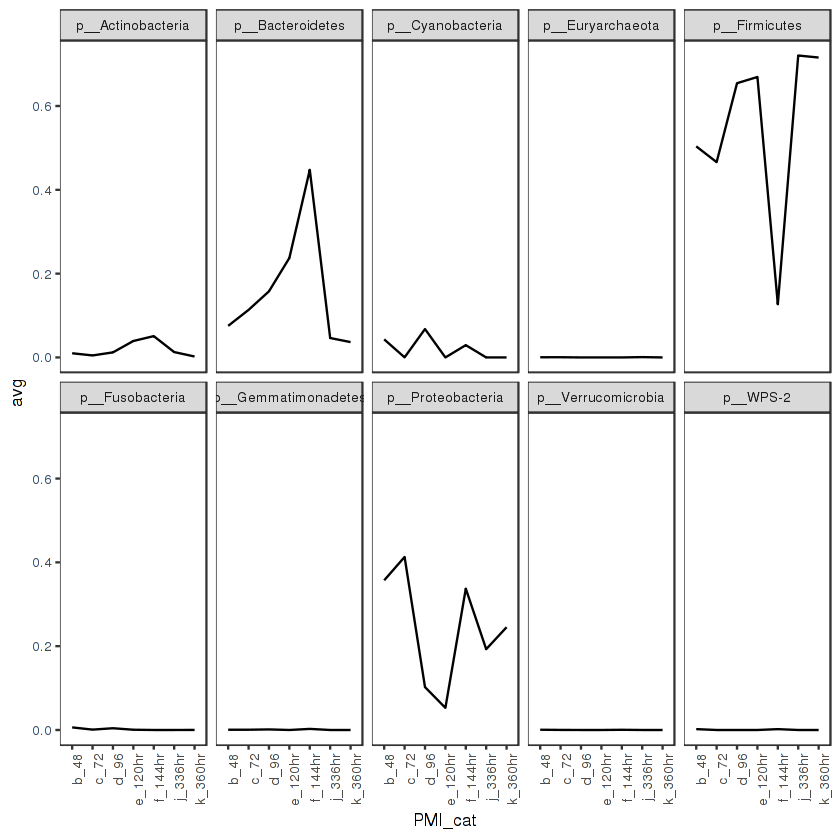

In [65]:
# Basic line plot with points
p = ggplot(data=uterus, aes(x=PMI_cat, y=avg, group=Phylum.other)) +
  geom_line() #+
  #geom_point()

p = p + facet_wrap(~Phylum.other, nrow=2)

p = p + theme_bw() + theme(text=element_text(size=10, color="black",family="Calibri"),
                           #legend.key = element_blank(),
                           axis.text.x = element_text(angle = 90, hjust = 1),
                           plot.title = element_text(hjust = 0.5),
                           legend.position = "bottom",
                           #axis.title.y=element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank())
p

png('/gpfs/data/gilbert-lab/Lutz/Cadaver/Italian_Cadaver/Oct2019_update/RelAbund/rank2.uterus.lines.png', width=10, height=10, units='in', res=300)
plot(p)
dev.off()